In [1]:
import os

from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

import torch
from torchvision.transforms import v2
from torch.utils.data import Subset
import random

from data.aleket_dataset import AleketDataset, download_dataset
from data.checkpoints import get_default_model, RunParams
from metrics.metrics import Evaluator
from inference.infer import infer
from utils.visualize import visualize_bboxes, draw_heat_map
from inference.predictor import Predictor, postprocess
from inference.models import FasterRCNN_ResNet50_FPN_v2
from config.consts import NUM_TO_CLASSES, VALIDATION_METRICS

In [2]:
def visualize_samples(dataset: AleketDataset, images_to_visualize=4):
    """
    Visualizes samples from the dataset with bounding boxes and labels.
    Randomly selects samples with annotations without loading all data first.

    Args:
        dataset (AleketDataset): The dataset to visualize samples from.
        images_to_visualize (int, optional): The number of images to visualize. Defaults to 4.
    """
    visualized_images = []
    dataset_length = len(dataset)
    sampled_indices = set()

    # Randomly sample indices until we get enough annotated images
    while len(visualized_images) < images_to_visualize and len(sampled_indices) < dataset_length:
        idx = random.randint(0, dataset_length - 1)
        if idx in sampled_indices:
            continue
        sampled_indices.add(idx)

        # Load only the randomly selected sample
        img, target = dataset[idx]
        if len(target["boxes"]) == 0:
            continue

        # Process image if it has annotations
        img = v2.functional.to_pil_image(img)
        bboxes = target["boxes"].cpu().tolist()
        labels = [NUM_TO_CLASSES[label] for label in target["labels"].cpu().tolist()]
        visualized_images.append(visualize_bboxes(img, bboxes, labels))

    # Dynamic grid layout based on actual found images
    columns = 4
    rows = (len(visualized_images) + columns - 1) // columns  # Ceiling division
    fig = plt.figure(figsize=(60, 20 * rows))
    
    for i in range(1, len(visualized_images) + 1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(visualized_images[i-1])
    
    plt.show()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

full_dataset = AleketDataset(download_dataset("../datasets/orobanche_cummana/images", ""))
patched_dataset = AleketDataset(download_dataset("../datasets/orobanche_cummana/patched/images", ""))

params = RunParams()
params.load("train_params.json")

model = FasterRCNN_ResNet50_FPN_v2("models/model.pth")

print(f"Model loaded")

SAVE_DIR = "eval"
os.makedirs(SAVE_DIR, exist_ok=True)

Using device: cuda
Model loaded


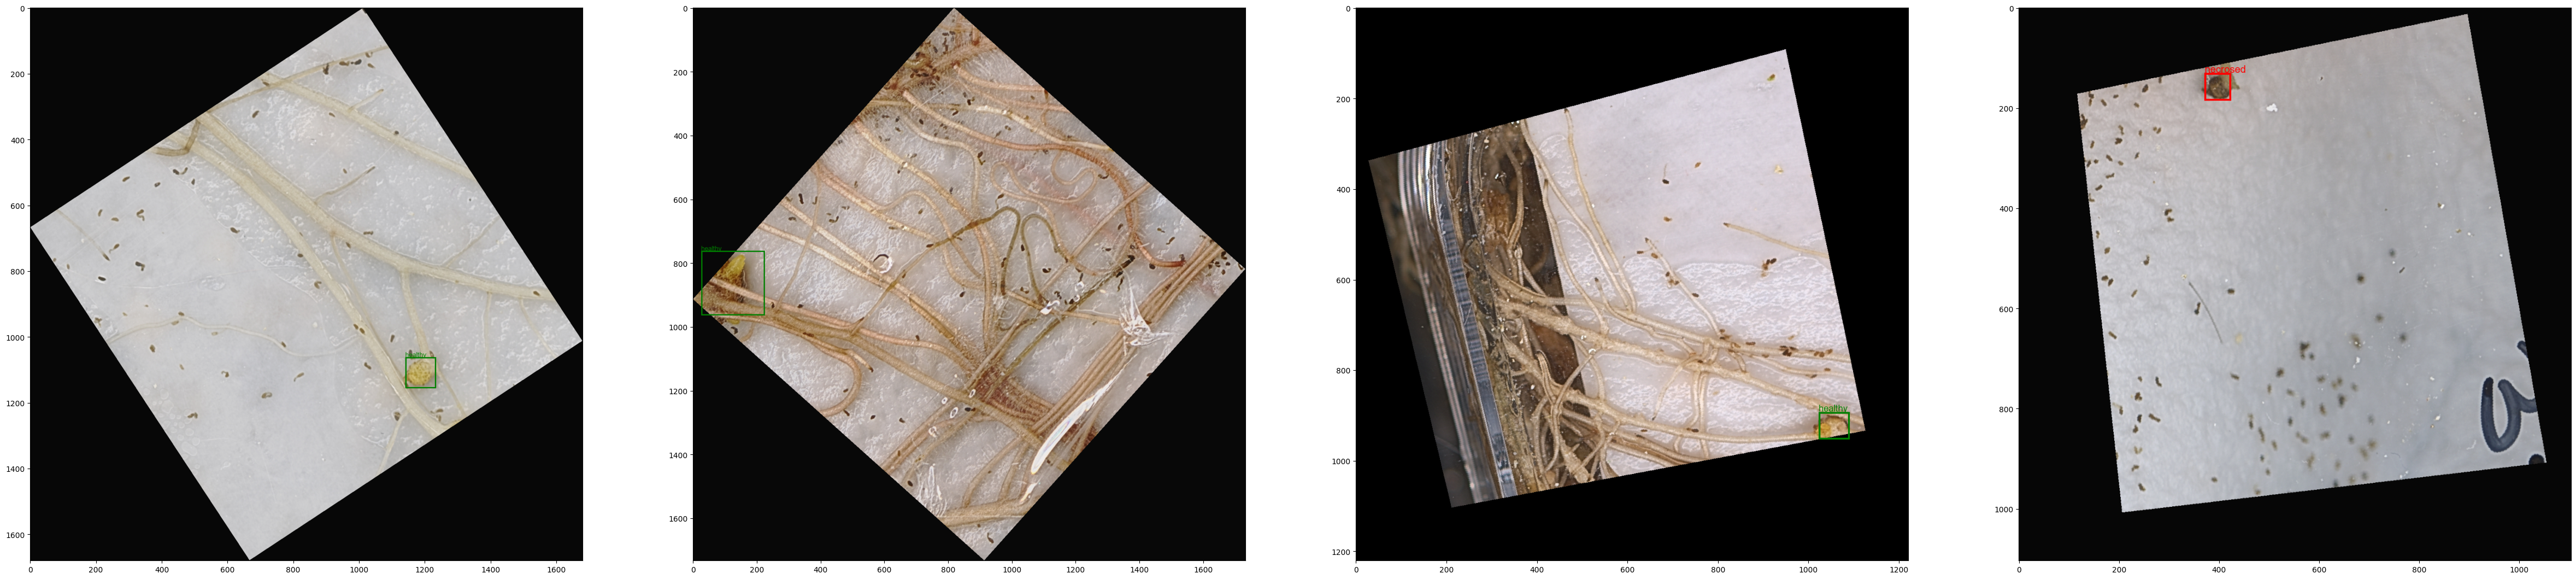

In [4]:
val_indices = full_dataset.load_split_indices("../datasets/orobanche_cummana/autosplit_val.txt")
val_subset = Subset(full_dataset, val_indices)

image_list = [full_dataset.image_files[ind] for ind in val_indices]

with open("val_image_list.txt", "w") as f:
    for name in image_list:
        f.write(os.path.normpath(name) + "\n")

parsed_params = params.parse(model.model, patched_dataset)
train_dataloader = parsed_params["train_loader"]
val_dataloader = parsed_params["val_loader"]
augmentation = parsed_params["augmentation"]


patched_dataset.augmentation = augmentation
visualize_samples(patched_dataset)

In [5]:
predictor = Predictor(
    model,
    device,
    detections_per_patch=300,
    pre_wbf_detections=2500,
    image_size_factor=1,
    patches_per_batch=8,
)

eval = Evaluator(full_dataset.get_annots(val_indices), use_categories=False)

In [6]:
preds = predictor.get_predictions(
    val_subset, 1, 0.05
)  # disable wbf postprocess (using small scorethreshold to increase performance)

In [ ]:
iou_thrs = np.round(np.flip(np.arange(0.1, 0.7 + 1e-3, 0.05)), 2)
score_thrs = np.round(np.arange(0.05, 0.95 + 1e-4, 0.05), 2)

np.savetxt(os.path.join(SAVE_DIR, "iou_thrs.csv"), iou_thrs, delimiter=",", fmt="%.2f")
np.savetxt(
    os.path.join(SAVE_DIR, "score_thrs.csv"), score_thrs, delimiter=",", fmt="%.2f"
)

N = len(iou_thrs)
S = len(score_thrs)

eval_res = {}
results_ap = np.full((N, S), -1.0)
results_p = np.full((N, S), -1.0)
results_r = np.full((N, S), -1.0)
results_aad = np.full((N, S), -1.0)
results_acd = np.full((N, S), -1.0)

print("start analyzing...")
for i, iou_thresh in enumerate(iou_thrs):
    for j, score_thresh in tqdm(enumerate(score_thrs), total=S):
        try:
            postproccessed = {}
            for pi, p in preds.items():
                to_process = {
                    "boxes": np.copy(p["boxes"]),
                    "scores": np.copy(p["scores"]),
                    "labels": np.copy(p["labels"])
                }
                postproccessed[pi] = postprocess(to_process,predictor.pre_wbf_detections, score_thresh, iou_thresh)
            stats = eval.eval(postproccessed)
            eval_res[(i, j)] = eval.eval_res
            results_ap[i, j] = stats[VALIDATION_METRICS[0]]
            results_acd[i, j] = stats[VALIDATION_METRICS[-2]]
            results_aad[i, j] = stats[VALIDATION_METRICS[-1]]
            results_p[i, j] = stats[VALIDATION_METRICS[2]]
            results_r[i, j] = stats[VALIDATION_METRICS[1]]
        except Exception as e:
            print(e)

start analyzing...


  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
np.savetxt(
    os.path.join(SAVE_DIR, "ap_analysis.csv"), results_ap, delimiter=",", fmt="%.4f"
)
np.savetxt(
    os.path.join(SAVE_DIR, "aad_analysis.csv"), results_aad, delimiter=",", fmt="%.4f"
)
np.savetxt(
    os.path.join(SAVE_DIR, "acd_analysis.csv"), results_acd, delimiter=",", fmt="%.4f"
)
np.savetxt(
    os.path.join(SAVE_DIR, "r_analysis.csv"), results_r, delimiter=",", fmt="%.4f"
)
np.savetxt(
    os.path.join(SAVE_DIR, "p_analysis.csv"), results_p, delimiter=",", fmt="%.4f"
)


fig, axes = plt.subplots(5, 1, figsize=(160, 30))

draw_heat_map(
    "AP",
    "Score thresholds",
    "IoU thresholds",
    results_ap,
    axes[0],
    score_thrs,
    iou_thrs,
)
draw_heat_map(
    "PRECISION",
    "Score thresholds",
    "IoU thresholds",
    results_p,
    axes[1],
    score_thrs,
    iou_thrs,
)
draw_heat_map(
    "RECALL",
    "Score thresholds",
    "IoU thresholds",
    results_r,
    axes[2],
    score_thrs,
    iou_thrs,
)
draw_heat_map(
    "AAD",
    "Score thresholds",
    "IoU thresholds",
    results_aad,
    axes[3],
    score_thrs,
    iou_thrs,
)
draw_heat_map(
    "ACD",
    "Score thresholds",
    "IoU thresholds",
    results_acd,
    axes[4],
    score_thrs,
    iou_thrs,
)

plt.tight_layout()
plt.show()

In [ ]:
BEST_IOU_THRESH = 0.25
BEST_SCORE_THRESH = 0.75

preds = predictor.get_predictions(val_subset, BEST_IOU_THRESH, BEST_SCORE_THRESH)

In [ ]:
eval = Evaluator(full_dataset.get_annots(val_indices), use_categories=False)
stats = eval.eval(preds)

print("ALL CLASSES METRICS:")
for metric_name, metric_value in stats.items():
    print(f"\tValidation {metric_name}: {metric_value:.3f}")

np.savetxt(os.path.join(SAVE_DIR, "pr_recalls.csv"), eval.recall_thrs, fmt="%.4f")
np.savetxt(
    os.path.join(SAVE_DIR, "pr_curve.csv"), eval.eval_res["pr_curve"], fmt="%.4f"
)

In [ ]:
infer(
    predictor,
    image_list,
    NUM_TO_CLASSES,
    os.path.join(SAVE_DIR, "infer"),
    iou_thresh=BEST_IOU_THRESH,
    score_thresh=BEST_SCORE_THRESH,
    save_annots=True,
    save_images=True,
)